In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from src.viz import plot_histograms
from scipy.stats.mstats import winsorize


%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] == 300

False

In [2]:
# reading the dataset
df = pd.read_csv('../data/raw/house_prices.csv')
df.sample(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
12713,Built-up Area,Ready To Move,Kothanur,3 BHK,EiionCa,1170,3.0,2.0,80.0
13177,Super built-up Area,Ready To Move,Bharathi Nagar,2 BHK,FoapeWa,1379,2.0,1.0,85.0
6269,Super built-up Area,Ready To Move,Whitefield,3 BHK,Sonviik,1495,2.0,NaN,67.0
1797,Built-up Area,Ready To Move,Chowdeshwari Layout,3 BHK,Keharya,1250,2.0,1.0,80.0
4333,Super built-up Area,Ready To Move,Whitefield,2 BHK,Nillsre,1415,2.0,3.0,67.0


In [3]:
# checking the shape of the data
df.shape

(13320, 9)

There are 13320 rows and 9 columns

In [4]:
# checking the dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


There are 3 numerical columns and 6 non-numerical columns in the dataset.

In [5]:
# looking at the summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bath,13247.0,2.692610,1.341458,1.0,2.0,2.0,3.0,40.0
balcony,12711.0,1.584376,0.817263,0.0,1.0,2.0,2.0,3.0
price,13320.0,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0


Bath: 
- Most properties have between 1 to 3 bathrooms, with a median of 2. 
- There is a property with an unusually high number of bathrooms (maximum of 40), suggesting a potential outlier.

Balcony:
- The majority of properties have 1 to 2 balconies, with a median of 2.
- The presence of properties with 0 balconies indicates that some units might not have a balcony.

Price:
- Prices vary widely, with a mean of approximately 112.57 and a large standard deviation of 148.97.
- The majority of properties have prices between 8 and 120, as indicated by the interquartile range (IQR).
- There is a substantial difference between the 75th percentile and the maximum price (3600), suggesting the presence of potential outliers.

# Data Cleaning 

There are 6 categorical columns and we cannot use categorical columns for linear regression.

- Dropping availability and society as they might not add anything to the model
- Dropping balcony column since it has a lot of missing values

In [6]:
# checking for missing values
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [7]:
# dropping availability and society column
df = df.drop(['availability','society','balcony','area_type'], axis=1)
# The rest of the missing values are really small amount incomparison to the entire size, hence dropping the null values
df = df.dropna()
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [8]:
# fixed the issue of missing value
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

Fixing sqft column as we would need in numeric format

In [9]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

We can see that there are some record that contain ranges of values
need to detect none float value and take the average of the range for getting a mean value to worth with

In [10]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [11]:
df[~df['total_sqft'].apply(is_float)].sample(5)

,location,size,total_sqft,bath,price
6552,5 Bedroom Farm House in Lakshmipura,5 Bedroom,24Guntha,6.0,550.000
6229,Bannerghatta Road,3 BHK,1365 - 1700,3.0,84.290
6643,Whitefield,4 BHK,2830 - 2882,5.0,157.500
9285,Hormavu,1 BHK,527 - 639,1.0,28.275
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800


There are some values that are in ranges and some that contains str like 142.84Sq. Meter

In [12]:
# creating a function to average the ranges
def convert_sqft(x):
    token = x.split('-')
    if len(token) == 2:
        return (float(token[0])+float(token[1]))/2
    try:
        return float(x)
    except: 
        return None

In [13]:
# applying the function
df['total_sqft'] = df['total_sqft'].apply(convert_sqft)
df.sample(5)

,location,size,total_sqft,bath,price
8845,Raghuvanahalli,1 BHK,420.0,1.0,23.50
11514,Haralur Road,2 BHK,1309.0,2.0,82.00
2496,banashankari stage iii sa,3 BHK,1411.0,3.0,91.72
8022,Mysore Road,3 BHK,1568.0,2.0,100.00
2032,Kanakpura Road,2 BHK,1296.0,2.0,89.00


In [14]:
# dropping these values as well
display(df.shape)
df = df.dropna()
df.shape

(13246, 5)

(13200, 5)

In [15]:
# cleaned the missing values
df.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

# Feature Engineering

There are discrepancies in the size column as some contain the suffix BHK and some contain the suffix Bedroom

In [16]:
# displaying all the unique objects in size attribute
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [17]:
# creating a new column with just the numbers of bedrooms
df['bhk'] = df['size'].apply(lambda x:int(x.split(' ')[0]))
df = df.drop('size', axis=1)
df.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [18]:
df.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

We can see there is a house which has 43 bedrooms, let's inspect that

In [19]:
# looking at all the records that have more than 20 bedrooms
df[df['bhk']>20]

,location,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,8000.0,27.0,230.0,27
4684,Munnekollal,2400.0,40.0,660.0,43


So, logically if a 8000 sqft house accomodates 27 bedrooms, then a 2000 sqft house shhould not accomodate more than 43 bedrooms. this can definetely be a case of outlier or misinput

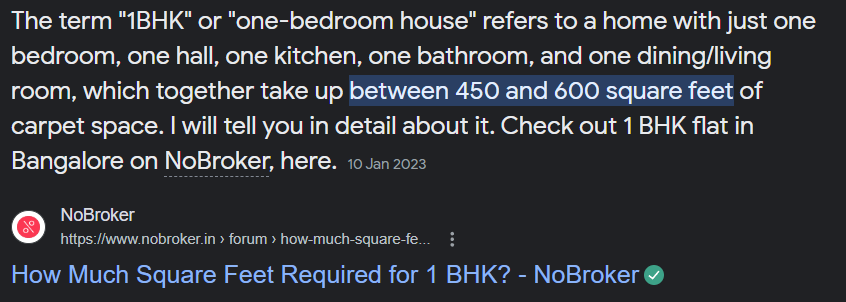

So to clean up discrepencies like that, we will be assuming that 1BHK has atleast 450 sqft area and then we will try to removed the unreasonable columns

In [20]:
df.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [21]:
print(df.shape)
# removing all the column that have discrepencies in total_sqft
df = df[~(df['total_sqft']/df['bhk']<450)]
df.shape

(13200, 5)


(10627, 5)

So in our dataset, the price is in Lakhs. and it gives you the price of `total_sqft`
- Creating `price_per_sqft` by dividing price by `total_sqft`

In [22]:
# creating the price per sqft column
df['price_per_sqft'] = df['price']*100000/df['total_sqft']
df.sample(5)

,location,total_sqft,bath,price,bhk,price_per_sqft
12586,Hegde Nagar,3734.0,5.0,430.0,4,11515.800750
9620,Hebbal,1200.0,2.0,48.0,2,4000.000000
2091,Whitefield,1485.0,2.0,90.0,2,6060.606061
7019,Hebbal,2850.0,5.0,343.0,3,12035.087719
531,Gattahalli,1028.0,2.0,45.5,2,4426.070039


We can certainly perform some dimensionality reduction on location column because as for a categorical column, it has a lot of distinct values

In [23]:
df.location.nunique()

1088

In [24]:
location_grouped = df.groupby('location')['location'].agg('count').sort_values(ascending=False)
other_locations = location_grouped[location_grouped<=10]

So we can classify those locations as other locations

In [25]:
display(df.location.nunique())
df.location = df.location.apply(lambda x: 'other' if x in other_locations else x)
df.location.nunique()

1088

194

Now we have 194 column, which is good because when converting it into categorical data, we won't have to deal with 1000 new columns, 200 is much more managable

# Outlier Treatment

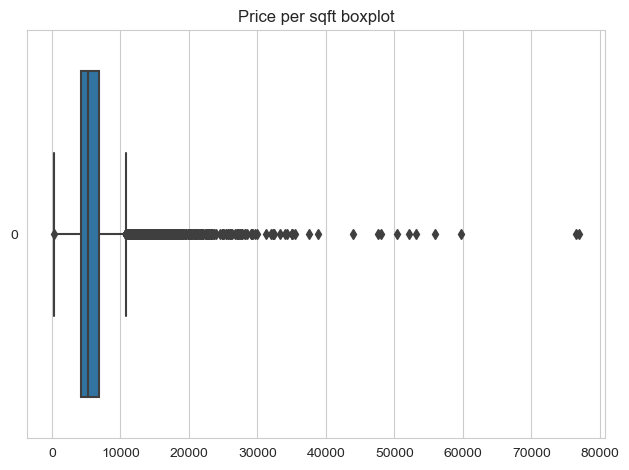

In [26]:
sns.boxplot(df['price_per_sqft'], orient='h')
plt.title('Price per sqft boxplot')
plt.tight_layout()
plt.show()

There are a lot of outlier, we need to reduce them, need to check the distribution of the data

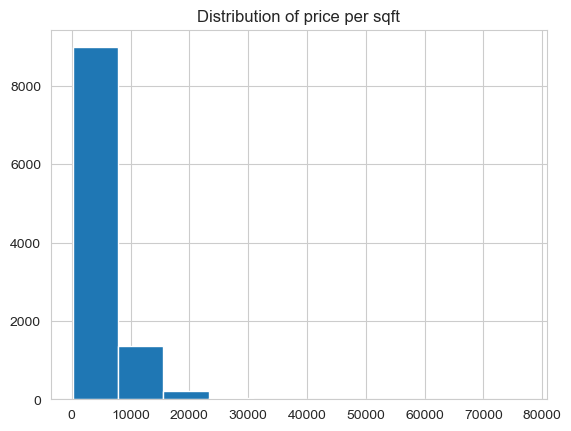

In [27]:
df['price_per_sqft'].hist()
plt.title('Distribution of price per sqft')
plt.show()

The distribution of `price_per_sqft` is skewed towards the right

In [28]:
df['price_per_sqft'].describe()

count    10627.000000
mean      6193.216738
std       3656.289661
min        267.829813
25%       4261.582324
50%       5331.882481
75%       6859.071438
max      76923.076923
Name: price_per_sqft, dtype: float64

In [29]:
# Replace extreme values with the maximum or minimum non-outlier values.
df['price_per_sqft'] = winsorize(df['price_per_sqft'], limits=[0.02, 0.02])

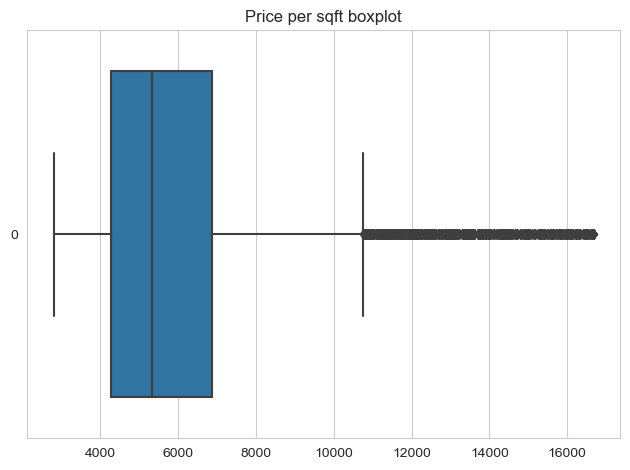

In [30]:
sns.boxplot(df['price_per_sqft'], orient='h')
plt.title('Price per sqft boxplot')
plt.tight_layout()
plt.show()

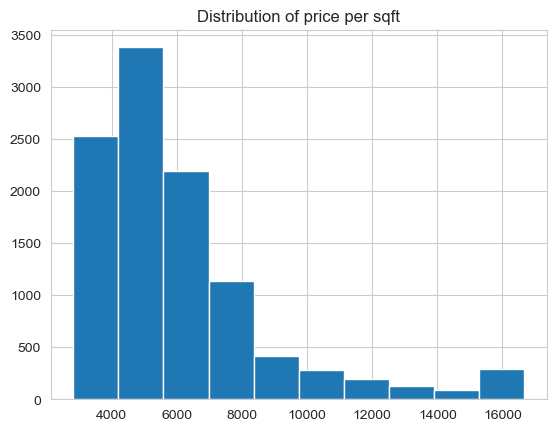

In [31]:
df['price_per_sqft'].hist()
plt.title('Distribution of price per sqft')
plt.show()

In [32]:
df['price_per_sqft'].describe()

c:\Users\Asif Sayyed\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


count    10627.000000
mean      6068.364438
std       2819.921241
min       2818.181818
25%       4261.582324
50%       5331.882481
75%       6859.071438
max      16666.666667
Name: price_per_sqft, dtype: float64

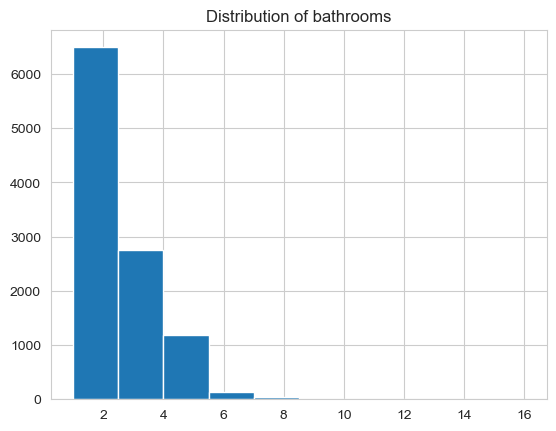

In [33]:
# looking at the bathroom attributes
df['bath'].hist()
plt.title('Distribution of bathrooms')
plt.show()

We can see, it ranges from 0 to 16 bathroom, hence we need to take a look at that

In [34]:
# checking the records with more than 10 bathroom
df[df.bath>10]

,location,total_sqft,bath,price,bhk,price_per_sqft
3096,other,12000.0,12.0,525.0,10,4375.000000
3609,other,10000.0,16.0,550.0,16,5500.000000
7979,other,6000.0,12.0,150.0,11,2818.181818
13067,other,7150.0,13.0,3600.0,10,16666.666667


I feel it is fair to assume that, number of bathroom will be either equal to the number of bedrooms or +2, anything beyond that should be classified as outlier

In [35]:
df[df['bath']> df['bhk']+2]

,location,total_sqft,bath,price,bhk,price_per_sqft
2620,other,11338.0,9.0,1000.0,6,8819.897689
6838,Rajaji Nagar,7500.0,8.0,1700.0,5,16666.666667
7709,other,2460.0,7.0,80.0,4,3252.032520
9974,other,2400.0,6.0,775.0,3,16666.666667
11366,other,7000.0,8.0,450.0,4,6428.571429
12103,Thanisandra,1806.0,6.0,116.0,3,6423.034330
12443,other,4350.0,8.0,2600.0,4,16666.666667
13067,other,7150.0,13.0,3600.0,10,16666.666667


Here we can see 6 BHK houses with 9 bathrooms and 5 BHK houses with 3 bathrooms. we can drop those as outliers

In [36]:
display(df.shape)
df = df[df['bath']< df['bhk']+2]
df.shape

(10627, 6)

(10489, 6)

Dropping `price_per_sqft` since we just created it for outlier detection

In [37]:
# dropping price_per_sqft column
display(df.shape)
df = df.drop('price_per_sqft', axis=1)
display(df.shape)

(10489, 6)

(10489, 5)

In [38]:
df.sample(5)

,location,total_sqft,bath,price,bhk
9285,Hormavu,583.0,1.0,28.275,1
7969,Talaghattapura,1856.0,3.0,135.000,3
9424,KR Puram,1085.0,2.0,46.500,2
9446,Electronic City Phase II,1140.0,2.0,28.500,2
12036,Sarjapur Road,1112.0,2.0,62.000,2


That's all the data cleaning and preprocessing that was needed

In [39]:
df.to_csv('../data/interim/house_prices_cleaned.csv',index=False)

<strong>Author</strong> <br>
Asif Sayyed<hr>
<b> Thanks for reading my code, ⭐ Star my repository if you find it useful </b><br>
<div>
    <li><a href="https://www.linkedin.com/in/sayyedasif/">LinkedIn</a></li>
    <li><a href="https://www.credly.com/users/asif-sayyed.fef49659/badges">Credly</a></li>
    <li><a href="https://asifdotexe.github.io/">Portfolio</a></li>
<div>